# Building a Libor Curve

This is an example of a replication of a BBG example from

https://github.com/vilen22/curve-building/blob/master/Bloomberg%20Curve%20Building%20Replication.xlsx

Agreement is very good however some issues about date generation need to be checked.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
#    FINANCEPY Version 1.1 - This build: 27 Aug 2025 at 23:27      #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Creating the Libor Instruments

In [3]:
value_dt = Date(6, 6, 2018)

### Load up the deposits first

In [4]:
spot_days = 0
settle_dt = value_dt.add_weekdays(spot_days)

In [5]:
depo_dcc_type = DayCountTypes.THIRTY_E_360_ISDA
depos = []
deposit_rate = 0.0231381
maturity_dt = settle_dt.add_months(3)
depo = IborDeposit(settle_dt, maturity_dt, deposit_rate, depo_dcc_type)
depos.append(depo)

### Create Strips of Interest Rate Futures 

In [6]:
futs = []
fut = IborFuture(value_dt, 1) ; futs.append(fut)
fut = IborFuture(value_dt, 2) ; futs.append(fut)
fut = IborFuture(value_dt, 3) ; futs.append(fut)
fut = IborFuture(value_dt, 4) ; futs.append(fut)
fut = IborFuture(value_dt, 5) ; futs.append(fut)
fut = IborFuture(value_dt, 6) ; futs.append(fut)

### Convert Interest Rate Futures to FRAs

Need to supply futures price and the convexity (in percent)

In [7]:
fras = [None]*6
fras[0] = futs[0].to_fra(97.6675,-0.00005)
fras[1] = futs[1].to_fra(97.5200,-0.00060)
fras[2] = futs[2].to_fra(97.3550,-0.00146)
fras[3] = futs[3].to_fra(97.2450,-0.00263)
fras[4] = futs[4].to_fra(97.1450,-0.00411)
fras[5] = futs[5].to_fra(97.0750,-0.00589)

### Then we load up swap rates

In [8]:
accrual = DayCountTypes.THIRTY_E_360
freq = FrequencyTypes.SEMI_ANNUAL
longEnd = DateGenRuleTypes.BACKWARD
swap_type = SwapTypes.PAY

In [9]:
spot_days = 2
settle_dt = value_dt.add_weekdays(spot_days)
notional = ONE_MILLION

In [10]:
swaps = []
swap = IborSwap(settle_dt, "2Y", swap_type, (2.77417+2.77844)/200, freq, accrual, notional); swaps.append(swap)
swap = IborSwap(settle_dt, "3Y", swap_type, (2.86098+2.86582)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "4Y", swap_type, (2.90240+2.90620)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "5Y", swap_type, (2.92944+2.92906)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "6Y", swap_type, (2.94001+2.94499)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "7Y", swap_type, (2.95352+2.95998)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "8Y", swap_type, (2.96830+2.97400)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "9Y", swap_type, (2.98403+2.98817)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "10Y", swap_type, (2.99716+3.00394)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "11Y", swap_type, (3.01344+3.01596)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "12Y", swap_type, (3.02276+3.02684)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "15Y", swap_type, (3.04092+3.04508)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "20Y", swap_type, (3.04417+3.05183)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "25Y", swap_type, (3.03219+3.03621)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "30Y", swap_type, (3.01030+3.01370)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "40Y", swap_type, (2.96946+2.97354)/200, freq, accrual); swaps.append(swap)
swap = IborSwap(settle_dt, "50Y", swap_type, (2.91552+2.93748)/200, freq, accrual); swaps.append(swap)

## Build the Curve

In [11]:
depos

[OBJECT TYPE: IborDeposit
 START DATE: 06-JUN-2018
 MATURITY DATE: 06-SEP-2018
 NOTIONAL: 100.0
 DEPOSIT RATE: 0.0231381
 DAY COUNT TYPE: DayCountTypes.THIRTY_E_360_ISDA
 CALENDAR: CalendarTypes.WEEKEND
 BUS DAY ADJUST TYPE: BusDayAdjustTypes.MODIFIED_FOLLOWING]

In [12]:
settle_dt

08-JUN-2018

In [13]:
libor_curve = IborSingleCurve(value_dt, depos, fras, swaps)

## Curve Examination

Generate a vector of time points and then generate zero rates and forward rates

In [14]:
years = np.linspace(0.01,50,1000)
dates = settle_dt.add_years(years)
zero_rates = libor_curve.zero_rate(dates)
fwd_rates = libor_curve.fwd(dates)

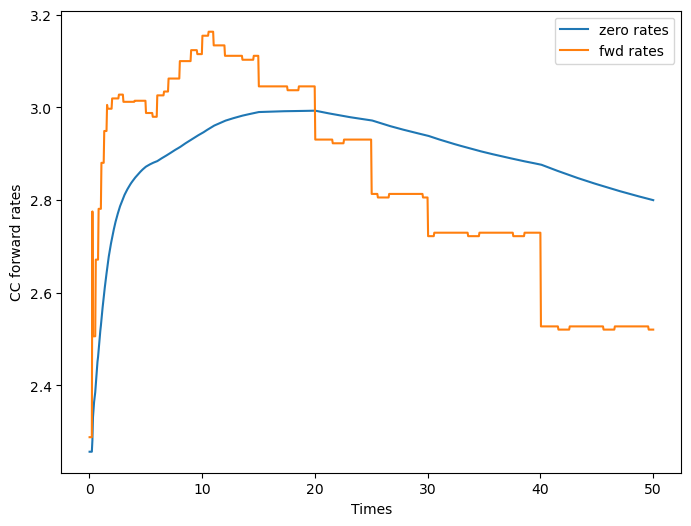

In [15]:
plt.figure(figsize=(8,6))
plt.plot(years, zero_rates*100, label="zero rates")
plt.plot(years, fwd_rates*100, label = "fwd rates")
plt.xlabel("Times")
plt.ylabel("CC forward rates")
plt.legend();

We see that the forward rates are piecewise flat

## Detailed Valuation

In [16]:
swaps[0].value(settle_dt, libor_curve, libor_curve)

-4.517110937740654e-06

In [17]:
swaps[0].fixed_leg.value(settle_dt, libor_curve)

-53715.21909367894

In [18]:
swaps[0].float_leg.value(settle_dt, libor_curve, libor_curve)

53715.21908916183

In [19]:
swaps[0].print_fixed_leg_pv()

START DATE: 08-JUN-2018
MATURITY DATE: 08-JUN-2020
COUPON (%): 2.776305
FREQUENCY: FrequencyTypes.SEMI_ANNUAL
DAY COUNT: DayCountTypes.THIRTY_E_360

PAYMENTS VALUATION:
PAY_NUM | PAY_dt      | NOTIONAL | RATE   | PMNT     | DF     | PV       | CUM_PV  
--------+-------------+----------+--------+----------+--------+----------+---------
      1 | 10-DEC-2018 |  1000000 | 2.7763 | 14035.76 | 0.9878 | 13864.72 | 13864.72
      2 | 10-JUN-2019 |  1000000 | 2.7763 | 13881.52 | 0.9745 | 13528.15 | 27392.87
      3 | 09-DEC-2019 |  1000000 | 2.7763 | 13804.41 | 0.9605 | 13259.45 | 40652.32
      4 | 08-JUN-2020 |  1000000 | 2.7763 | 13804.41 | 0.9463 |  13062.9 | 53715.22


In [20]:
swaps[0].print_float_leg_pv()

START DATE: 08-JUN-2018
MATURITY DATE: 08-JUN-2020
SPREAD (BPS): 0.0
FREQUENCY: FrequencyTypes.QUARTERLY
DAY COUNT: DayCountTypes.THIRTY_E_360

PAYMENTS VALUATION:
PAY_NUM | PAY_dt      | NOTIONAL | IBOR   | PMNT    | DF     | PV      | CUM_PV  
--------+-------------+----------+--------+---------+--------+---------+---------
      1 | 10-SEP-2018 |  1000000 | 2.3339 | 5964.33 | 0.9941 | 5928.97 |  5928.97
      2 | 10-DEC-2018 |  1000000 | 2.5337 | 6334.19 | 0.9878 | 6257.01 | 12185.97
      3 | 08-MAR-2019 |  1000000 | 2.6265 | 6420.24 | 0.9815 | 6301.55 | 18487.52
      4 | 10-JUN-2019 |  1000000 | 2.7983 | 7151.28 | 0.9745 | 6969.23 | 25456.75
      5 | 09-SEP-2019 |  1000000 |  2.905 | 7181.78 | 0.9676 | 6949.05 |  32405.8
      6 | 09-DEC-2019 |  1000000 | 2.9447 | 7361.81 | 0.9605 | 7071.18 | 39476.98
      7 | 09-MAR-2020 |  1000000 | 2.9963 | 7490.76 | 0.9534 | 7141.55 | 46618.54
      8 | 08-JUN-2020 |  1000000 | 3.0335 | 7499.52 | 0.9463 | 7096.68 | 53715.22


Copyright (c) 2020 Dominic O'Kane